# Load Data

In [ ]:
! pip install pytorch_pretrained_bert
! pip install torchmetrics
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Capstone')
from utils import read_conll_file, read_data, filter_tag, create_sub_dir
from utils import (TAG2IDX, IDX2TAG, DATA_DIR, WSJ_DIR, MODEL_DIR, 
                   INT_RESULT_DIR, METRICS_DIR, RESULT_DIR, PLOT_TAGS_DIR)
from utils import wsj_train_word_lst, wsj_train_tag_lst, wsj_test_word_lst, wsj_test_tag_lst

from build_model import PosDataset, Net, DEVICE, TOKENIZER
from build_model import pad, train, eval

from analysis import save_sns_fig, save_plotly_fig, analysis_output

from create_pseudo_data import gen_pseudo_data

import os
from collections import Counter
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer, BertModel
from torchmetrics.functional.classification import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy

torch.manual_seed(0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The number of samples: 30060
The number of tags 48
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45


In [ ]:
model = Net(vocab_size=len(TAG2IDX))
model.to(DEVICE)
model = nn.DataParallel(model)

In [ ]:
train_dataset = PosDataset(wsj_train_word_lst, wsj_train_tag_lst)
eval_dataset = PosDataset(wsj_test_word_lst, wsj_test_tag_lst)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=8,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
test_iter = data.DataLoader(dataset=eval_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
model_file = os.path.join(MODEL_DIR, "base_model.pt")
model.load_state_dict(torch.load(model_file))
(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value, 
 micro_wsj_precision_value, micro_wsj_recall_value, micro_wsj_f1_value, micro_wsj_acc_value,
 macro_wsj_precision_value, macro_wsj_recall_value, macro_wsj_f1_value, macro_wsj_acc_value) = eval(model, test_iter, save_output=False)

print(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value)
print(micro_wsj_precision_value, micro_wsj_recall_value, micro_wsj_f1_value, micro_wsj_acc_value)
print(macro_wsj_precision_value, macro_wsj_recall_value, macro_wsj_f1_value, macro_wsj_acc_value)


tensor(0.9771) tensor(0.9743) tensor(0.9751) tensor(0.9743)
tensor(0.9743) tensor(0.9743) tensor(0.9743) tensor(0.9743)
tensor(0.8648) tensor(0.8656) tensor(0.8558) tensor(0.8656)


# Self Training

In [ ]:
file_name_lst = ["answers", "emails", "newsgroups", "reviews", "weblogs"]

In [ ]:
domain = "newsgroups"
domain_dir = os.path.join(DATA_DIR, "pos_fine", f"{domain}")
domain_dev_file = os.path.join(domain_dir, f"gweb-{domain}-dev.conll")
domain_test_file = os.path.join(domain_dir, f"gweb-{domain}-test.conll")

In [ ]:
domain_dev_word_lst, domain_dev_tag_lst, domain_dev_tag_set = read_data(domain_dev_file)
domain_test_word_lst, domain_test_tag_lst, domain_test_tag_set = read_data(domain_test_file)
domain_dev_word_lst, domain_dev_tag_lst = filter_tag(domain_dev_word_lst, domain_dev_tag_lst)  
domain_test_word_lst, domain_test_tag_lst = filter_tag(domain_test_word_lst, domain_test_tag_lst)

The number of samples: 1196
The number of tags 49
The number of samples: 1195
The number of tags 49
after filter tag 1190
after filter tag 1180


In [ ]:
# method_name: Online_fixed_self_learning, Online_nonfixed_self_learning, 
#               Scratch_fixed_self_learning, Scratch_nonfixed_self_learning,
#               Online_token_self_learning, Scratch_token_self_learning

(sub_model_dir, sub_metrics_dir, sub_result_dir, 
 sub_plots_tags_dir, sub_int_res_dir) = create_sub_dir(domain, method_name="Scratch_nonfixed_self_learning")

Create /content/drive/MyDrive/Colab Notebooks/Capstone/model/Scratch_nonfixed_self_learning/newsgroups
Create /content/drive/MyDrive/Colab Notebooks/Capstone/metrics/Scratch_nonfixed_self_learning/newsgroups
Create /content/drive/MyDrive/Colab Notebooks/Capstone/result/Scratch_nonfixed_self_learning/newsgroups
Create /content/drive/MyDrive/Colab Notebooks/Capstone/plots_tags/Scratch_nonfixed_self_learning/newsgroups
Create /content/drive/MyDrive/Colab Notebooks/Capstone/intermediate_result/Scratch_nonfixed_self_learning/newsgroups


In [ ]:
domain_precision_value_lst = []
domain_recall_value_lst = []
domain_f1_value_lst = []
domain_acc_value_lst = []

micro_domain_precision_value_lst = []
micro_domain_recall_value_lst = []
micro_domain_f1_value_lst = []
micro_domain_acc_value_lst = []

macro_domain_precision_value_lst = []
macro_domain_recall_value_lst = []
macro_domain_f1_value_lst = []
macro_domain_acc_value_lst = []

In [ ]:
loop_i = 0
threshold = 0.02
top_percent = 0.6

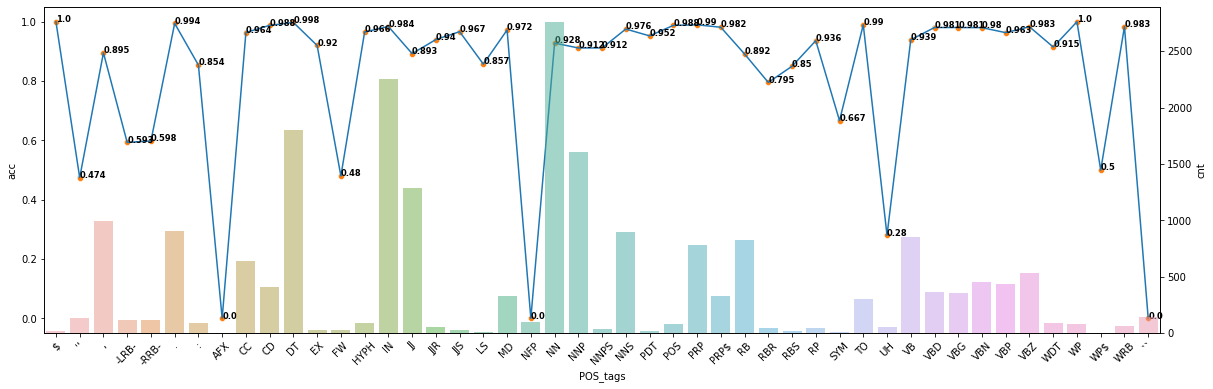

In [ ]:
domain_test_dataset = PosDataset(domain_test_word_lst, domain_test_tag_lst)

domain_test_iter = data.DataLoader(dataset=domain_test_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

output_res_file = os.path.join(sub_result_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.txt")
(domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value,
 precision_value_micro, recall_value_micro, f1_value_micro, acc_micro, 
 precision_value_macro, recall_value_macro, f1_value_macro, acc_macro) = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

csv_file_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.csv")
output_plot_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.png")
_ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)

domain_precision_value_lst.append(domain_precision_value)
domain_recall_value_lst.append(domain_recall_value)
domain_f1_value_lst.append(domain_f1_value)
domain_acc_value_lst.append(domain_acc_value)

micro_domain_precision_value_lst.append(precision_value_micro)
micro_domain_recall_value_lst.append(recall_value_micro)
micro_domain_f1_value_lst.append(f1_value_micro)
micro_domain_acc_value_lst.append(acc_micro)

macro_domain_precision_value_lst.append(precision_value_macro)
macro_domain_recall_value_lst.append(recall_value_macro)
macro_domain_f1_value_lst.append(f1_value_macro)
macro_domain_acc_value_lst.append(acc_macro)


The number of sentences in top n 714
Stop condation 14

Loop 1
Difference 701


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.95275616645813
step: 10, loss: 1.9343923330307007
step: 20, loss: 0.6500889658927917
step: 30, loss: 0.3346570134162903
step: 40, loss: 0.37137457728385925
step: 50, loss: 0.30930882692337036
step: 60, loss: 0.18557478487491608
step: 70, loss: 0.2511448562145233
step: 80, loss: 0.15291114151477814
step: 90, loss: 0.13846513628959656
step: 100, loss: 0.1631041020154953
step: 110, loss: 0.14124998450279236
step: 120, loss: 0.15762518346309662
step: 130, loss: 0.20210842788219452
step: 140, loss: 0.0937880203127861
step: 150, loss: 0.08412406593561172
step: 160, loss: 0.15747632086277008
step: 170, loss: 0.21856290102005005
step: 180, loss: 0.13896839320659637
step: 190, loss: 0.11151473969221115
step: 200, loss: 0.04765203222632408
step: 210, loss: 0.14605887234210968
step: 220, loss: 0.17474032938480377
step: 230, loss: 0.062106382101774216
step: 240, loss: 0.190086230635643
step: 250, loss: 0.05978797748684883
step: 260, loss: 0.19203586876392365


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 4.0154032707214355
step: 10, loss: 2.065099000930786
step: 20, loss: 1.0185121297836304
step: 30, loss: 0.3845297694206238
step: 40, loss: 0.20157454907894135
step: 50, loss: 0.23670406639575958
step: 60, loss: 0.22966623306274414
step: 70, loss: 0.32925140857696533
step: 80, loss: 0.20404809713363647
step: 90, loss: 0.17413604259490967
step: 100, loss: 0.25726065039634705
step: 110, loss: 0.23467738926410675
step: 120, loss: 0.19717054069042206
step: 130, loss: 0.05574518069624901
step: 140, loss: 0.09693889319896698
step: 150, loss: 0.27530136704444885
step: 160, loss: 0.12745752930641174
step: 170, loss: 0.17341651022434235
step: 180, loss: 0.12740640342235565
step: 190, loss: 0.06314685195684433
step: 200, loss: 0.14296717941761017
step: 210, loss: 0.10189280658960342
step: 220, loss: 0.07359810918569565
step: 230, loss: 0.19181489944458008
step: 240, loss: 0.12260670214891434
step: 250, loss: 0.08386897295713425
step: 260, loss: 0.1640295535326

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.915894031524658
step: 10, loss: 1.6885571479797363
step: 20, loss: 0.750316858291626
step: 30, loss: 0.5283282399177551
step: 40, loss: 0.22747081518173218
step: 50, loss: 0.18171916902065277
step: 60, loss: 0.11507391184568405
step: 70, loss: 0.19508977234363556
step: 80, loss: 0.17670251429080963
step: 90, loss: 0.26241156458854675
step: 100, loss: 0.2019004225730896
step: 110, loss: 0.1157049834728241
step: 120, loss: 0.2469833791255951
step: 130, loss: 0.19478675723075867
step: 140, loss: 0.09996131807565689
step: 150, loss: 0.1947590857744217
step: 160, loss: 0.08898573368787766
step: 170, loss: 0.1674283891916275
step: 180, loss: 0.12214799970388412
step: 190, loss: 0.12837104499340057
step: 200, loss: 0.3426157236099243
step: 210, loss: 0.162233367562294
step: 220, loss: 0.13338015973567963
step: 230, loss: 0.14809824526309967
step: 240, loss: 0.1986667364835739
step: 250, loss: 0.24001574516296387
step: 260, loss: 0.14308220148086548
step:

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.9213333129882812
step: 10, loss: 1.80991530418396
step: 20, loss: 0.6544695496559143
step: 30, loss: 0.3904561400413513
step: 40, loss: 0.3647882640361786
step: 50, loss: 0.2454390972852707
step: 60, loss: 0.17939965426921844
step: 70, loss: 0.14839084446430206
step: 80, loss: 0.1258544772863388
step: 90, loss: 0.1029452532529831
step: 100, loss: 0.1614936888217926
step: 110, loss: 0.16995801031589508
step: 120, loss: 0.21550701558589935
step: 130, loss: 0.20430897176265717
step: 140, loss: 0.13618400692939758
step: 150, loss: 0.16764451563358307
step: 160, loss: 0.10719550400972366
step: 170, loss: 0.22310566902160645
step: 180, loss: 0.15229621529579163
step: 190, loss: 0.20454049110412598
step: 200, loss: 0.10482142865657806
step: 210, loss: 0.20350287854671478
step: 220, loss: 0.08422654122114182
step: 230, loss: 0.17327916622161865
step: 240, loss: 0.11302275210618973
step: 250, loss: 0.20628097653388977
step: 260, loss: 0.1653851866722107
st

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.9566686153411865
step: 10, loss: 1.9757746458053589
step: 20, loss: 0.7654680013656616
step: 30, loss: 0.3512856066226959
step: 40, loss: 0.3884659707546234
step: 50, loss: 0.2125215381383896
step: 60, loss: 0.13576872646808624
step: 70, loss: 0.14225611090660095
step: 80, loss: 0.2341378629207611
step: 90, loss: 0.2623556852340698
step: 100, loss: 0.13698460161685944
step: 110, loss: 0.23268020153045654
step: 120, loss: 0.14804497361183167
step: 130, loss: 0.08459670096635818
step: 140, loss: 0.17569974064826965
step: 150, loss: 0.2138611525297165
step: 160, loss: 0.21658922731876373
step: 170, loss: 0.1022910624742508
step: 180, loss: 0.06525617837905884
step: 190, loss: 0.12979330122470856
step: 200, loss: 0.14541222155094147
step: 210, loss: 0.1603025645017624
step: 220, loss: 0.2355339229106903
step: 230, loss: 0.11950390785932541
step: 240, loss: 0.10977821797132492
step: 250, loss: 0.11666783690452576
step: 260, loss: 0.1462421417236328
ste

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.993134021759033
step: 10, loss: 1.782718300819397
step: 20, loss: 0.6710706353187561
step: 30, loss: 0.6036053895950317
step: 40, loss: 0.3479641079902649
step: 50, loss: 0.297922819852829
step: 60, loss: 0.1647564321756363
step: 70, loss: 0.23132964968681335
step: 80, loss: 0.17967768013477325
step: 90, loss: 0.1563269942998886
step: 100, loss: 0.26911717653274536
step: 110, loss: 0.1825152486562729
step: 120, loss: 0.1780608743429184
step: 130, loss: 0.10084792971611023
step: 140, loss: 0.09510121494531631
step: 150, loss: 0.07296765595674515
step: 160, loss: 0.13962343335151672
step: 170, loss: 0.09487313032150269
step: 180, loss: 0.13661783933639526
step: 190, loss: 0.09183372557163239
step: 200, loss: 0.10061221569776535
step: 210, loss: 0.10686252266168594
step: 220, loss: 0.10262655466794968
step: 230, loss: 0.11769494414329529
step: 240, loss: 0.26637861132621765
step: 250, loss: 0.13280464708805084
step: 260, loss: 0.12387099117040634
ste

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.985471248626709
step: 10, loss: 1.9336344003677368
step: 20, loss: 0.9573515057563782
step: 30, loss: 0.4131035804748535
step: 40, loss: 0.25832438468933105
step: 50, loss: 0.28754639625549316
step: 60, loss: 0.1843964010477066
step: 70, loss: 0.11801940947771072
step: 80, loss: 0.07691500335931778
step: 90, loss: 0.16366124153137207
step: 100, loss: 0.19306538999080658
step: 110, loss: 0.09841153025627136
step: 120, loss: 0.21546345949172974
step: 130, loss: 0.14859339594841003
step: 140, loss: 0.06812863796949387
step: 150, loss: 0.09243205189704895
step: 160, loss: 0.09752710908651352
step: 170, loss: 0.14415425062179565
step: 180, loss: 0.07951730489730835
step: 190, loss: 0.07067222893238068
step: 200, loss: 0.2081218808889389
step: 210, loss: 0.07020176947116852
step: 220, loss: 0.13932904601097107
step: 230, loss: 0.16988113522529602
step: 240, loss: 0.19806058704853058
step: 250, loss: 0.13662950694561005
step: 260, loss: 0.088690020143985

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 4.111663818359375
step: 10, loss: 2.2657389640808105
step: 20, loss: 0.9165468215942383
step: 30, loss: 0.41728171706199646
step: 40, loss: 0.24776463210582733
step: 50, loss: 0.23424097895622253
step: 60, loss: 0.1537506878376007
step: 70, loss: 0.31908270716667175
step: 80, loss: 0.19493821263313293
step: 90, loss: 0.24591796100139618
step: 100, loss: 0.18216797709465027
step: 110, loss: 0.1980656534433365
step: 120, loss: 0.16088341176509857
step: 130, loss: 0.08229491114616394
step: 140, loss: 0.08825865387916565
step: 150, loss: 0.09702184051275253
step: 160, loss: 0.05335158854722977
step: 170, loss: 0.16274699568748474
step: 180, loss: 0.1380486637353897
step: 190, loss: 0.17489156126976013
step: 200, loss: 0.09849114716053009
step: 210, loss: 0.11134985089302063
step: 220, loss: 0.041954249143600464
step: 230, loss: 0.09904339164495468
step: 240, loss: 0.06676942855119705
step: 250, loss: 0.04738765209913254
step: 260, loss: 0.09606274217367

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.9084620475769043
step: 10, loss: 1.7328771352767944
step: 20, loss: 0.840934693813324
step: 30, loss: 0.3625534772872925
step: 40, loss: 0.46173205971717834
step: 50, loss: 0.28025051951408386
step: 60, loss: 0.185928076505661
step: 70, loss: 0.23101715743541718
step: 80, loss: 0.15060529112815857
step: 90, loss: 0.15494365990161896
step: 100, loss: 0.1369071900844574
step: 110, loss: 0.11529447883367538
step: 120, loss: 0.20995330810546875
step: 130, loss: 0.1327606737613678
step: 140, loss: 0.12930725514888763
step: 150, loss: 0.11593998223543167
step: 160, loss: 0.1732926368713379
step: 170, loss: 0.21450527012348175
step: 180, loss: 0.13124383985996246
step: 190, loss: 0.13879626989364624
step: 200, loss: 0.13246841728687286
step: 210, loss: 0.07656410336494446
step: 220, loss: 0.16336722671985626
step: 230, loss: 0.08571852743625641
step: 240, loss: 0.11511973291635513
step: 250, loss: 0.22248613834381104
step: 260, loss: 0.04840824753046036


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


Train from scratch...
step: 0, loss: 3.8955276012420654
step: 10, loss: 2.017767906188965
step: 20, loss: 0.6989177465438843
step: 30, loss: 0.3149171471595764
step: 40, loss: 0.19846856594085693
step: 50, loss: 0.19599705934524536
step: 60, loss: 0.1888311505317688
step: 70, loss: 0.33638787269592285
step: 80, loss: 0.2297847419977188
step: 90, loss: 0.16013318300247192
step: 100, loss: 0.14804616570472717
step: 110, loss: 0.156727597117424
step: 120, loss: 0.039758581668138504
step: 130, loss: 0.166300430893898
step: 140, loss: 0.10424023866653442
step: 150, loss: 0.2001378834247589
step: 160, loss: 0.10943154990673065
step: 170, loss: 0.2552120089530945
step: 180, loss: 0.20116855204105377
step: 190, loss: 0.1375504583120346
step: 200, loss: 0.04111670330166817
step: 210, loss: 0.26206955313682556
step: 220, loss: 0.14360469579696655
step: 230, loss: 0.08882474154233932
step: 240, loss: 0.07045034319162369
step: 250, loss: 0.11683689802885056
step: 260, loss: 0.15734289586544037
ste

/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,
/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Train from scratch...
step: 0, loss: 3.9518516063690186
step: 10, loss: 1.7605769634246826
step: 20, loss: 0.7413784265518188
step: 30, loss: 0.42422932386398315
step: 40, loss: 0.215375155210495
step: 50, loss: 0.16019368171691895
step: 60, loss: 0.2744777202606201
step: 70, loss: 0.1375121921300888
step: 80, loss: 0.14575105905532837
step: 90, loss: 0.18752069771289825
step: 100, loss: 0.17947658896446228
step: 110, loss: 0.1191675066947937
step: 120, loss: 0.1574699431657791
step: 130, loss: 0.12465649098157883
step: 140, loss: 0.17503546178340912
step: 150, loss: 0.21300771832466125
step: 160, loss: 0.21376077830791473
step: 170, loss: 0.07232300937175751
step: 180, loss: 0.06761305779218674
step: 190, loss: 0.1575092226266861
step: 200, loss: 0.17397631704807281
step: 210, loss: 0.09712868183851242
step: 220, loss: 0.17351102828979492
step: 230, loss: 0.14369766414165497
step: 240, loss: 0.08354891836643219
step: 250, loss: 0.06652883440256119
step: 260, loss: 0.14002791047096252


/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))



Loop 12
Difference 114


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,
/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Train from scratch...
step: 0, loss: 3.904352903366089
step: 10, loss: 1.9412046670913696
step: 20, loss: 1.0212496519088745
step: 30, loss: 0.3524806797504425
step: 40, loss: 0.4565451443195343
step: 50, loss: 0.2178032100200653
step: 60, loss: 0.3327971398830414
step: 70, loss: 0.18173253536224365
step: 80, loss: 0.29223620891571045
step: 90, loss: 0.10207577794790268
step: 100, loss: 0.12985578179359436
step: 110, loss: 0.17436987161636353
step: 120, loss: 0.18419888615608215
step: 130, loss: 0.16976898908615112
step: 140, loss: 0.0558786541223526
step: 150, loss: 0.11622835695743561
step: 160, loss: 0.12859684228897095
step: 170, loss: 0.09664348512887955
step: 180, loss: 0.06535230576992035
step: 190, loss: 0.08495686203241348
step: 200, loss: 0.0809006616473198
step: 210, loss: 0.12874755263328552
step: 220, loss: 0.09210396558046341
step: 230, loss: 0.16123516857624054
step: 240, loss: 0.1299809366464615
step: 250, loss: 0.12803488969802856
step: 260, loss: 0.1266152560710907
st

/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))



Loop 13
Difference 106


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,
/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Train from scratch...
step: 0, loss: 3.9344890117645264
step: 10, loss: 1.7358381748199463
step: 20, loss: 0.9008341431617737
step: 30, loss: 0.4912565350532532
step: 40, loss: 0.24360215663909912
step: 50, loss: 0.2410052865743637
step: 60, loss: 0.21652868390083313
step: 70, loss: 0.18952922523021698
step: 80, loss: 0.19524963200092316
step: 90, loss: 0.09798894822597504
step: 100, loss: 0.1485232412815094
step: 110, loss: 0.16629497706890106
step: 120, loss: 0.07819201052188873
step: 130, loss: 0.09008300304412842
step: 140, loss: 0.1716683804988861
step: 150, loss: 0.10377740114927292
step: 160, loss: 0.18063177168369293
step: 170, loss: 0.0793461799621582
step: 180, loss: 0.13981416821479797
step: 190, loss: 0.18027031421661377
step: 200, loss: 0.10673332214355469
step: 210, loss: 0.07668637484312057
step: 220, loss: 0.07310618460178375
step: 230, loss: 0.1571774035692215
step: 240, loss: 0.06708674877882004
step: 250, loss: 0.1514674872159958
step: 260, loss: 0.0812896192073822
s

/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))



Loop 14
Difference 101


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,
/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Train from scratch...
step: 0, loss: 3.9617393016815186
step: 10, loss: 2.1787173748016357
step: 20, loss: 0.677141547203064
step: 30, loss: 0.4614940285682678
step: 40, loss: 0.32808220386505127
step: 50, loss: 0.41828325390815735
step: 60, loss: 0.2426803559064865
step: 70, loss: 0.19082406163215637
step: 80, loss: 0.20674651861190796
step: 90, loss: 0.34730497002601624
step: 100, loss: 0.08914842456579208
step: 110, loss: 0.10998425632715225
step: 120, loss: 0.08937240391969681
step: 130, loss: 0.08699353039264679
step: 140, loss: 0.2197088748216629
step: 150, loss: 0.1556108444929123
step: 160, loss: 0.10921137034893036
step: 170, loss: 0.0455196350812912
step: 180, loss: 0.11617200076580048
step: 190, loss: 0.2551196813583374
step: 200, loss: 0.23438844084739685
step: 210, loss: 0.17436234652996063
step: 220, loss: 0.19207763671875
step: 230, loss: 0.06899242848157883
step: 240, loss: 0.09690660983324051
step: 250, loss: 0.09316108375787735
step: 260, loss: 0.07787216454744339
ste

/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))



Loop 15
Difference 109


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,
/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Train from scratch...
step: 0, loss: 3.8591251373291016
step: 10, loss: 1.8564528226852417
step: 20, loss: 0.9203745126724243
step: 30, loss: 0.45562177896499634
step: 40, loss: 0.20890431106090546
step: 50, loss: 0.19266563653945923
step: 60, loss: 0.29181188344955444
step: 70, loss: 0.15322016179561615
step: 80, loss: 0.16351214051246643
step: 90, loss: 0.17480649054050446
step: 100, loss: 0.1176077127456665
step: 110, loss: 0.10467805713415146
step: 120, loss: 0.13839603960514069
step: 130, loss: 0.07816578447818756
step: 140, loss: 0.1447073370218277
step: 150, loss: 0.17143113911151886
step: 160, loss: 0.12811581790447235
step: 170, loss: 0.11106240749359131
step: 180, loss: 0.06892272084951401
step: 190, loss: 0.08366546779870987
step: 200, loss: 0.09762389212846756
step: 210, loss: 0.15225760638713837
step: 220, loss: 0.06260474026203156
step: 230, loss: 0.19848096370697021
step: 240, loss: 0.19539538025856018
step: 250, loss: 0.12374980002641678
step: 260, loss: 0.0853978842496

/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


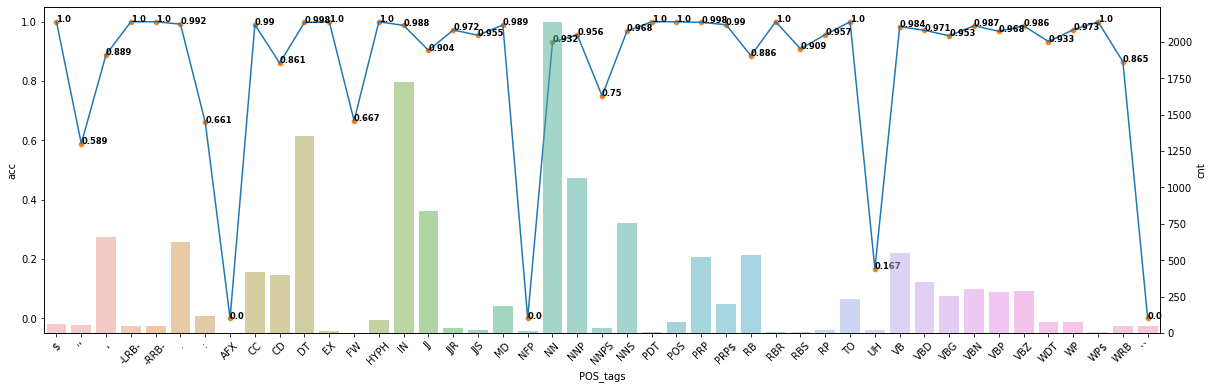

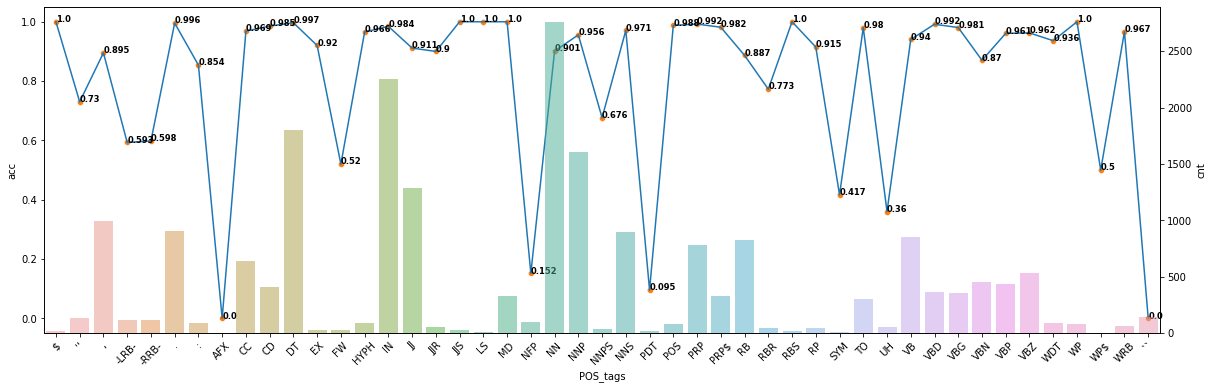

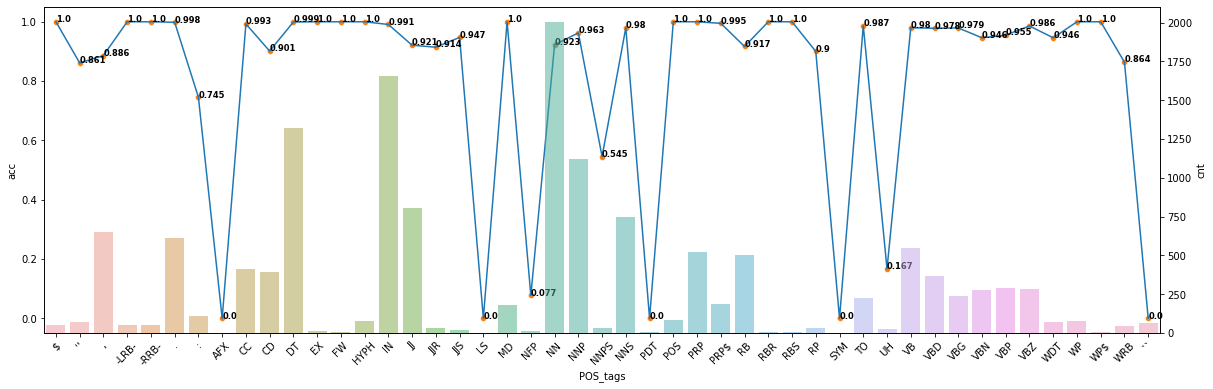

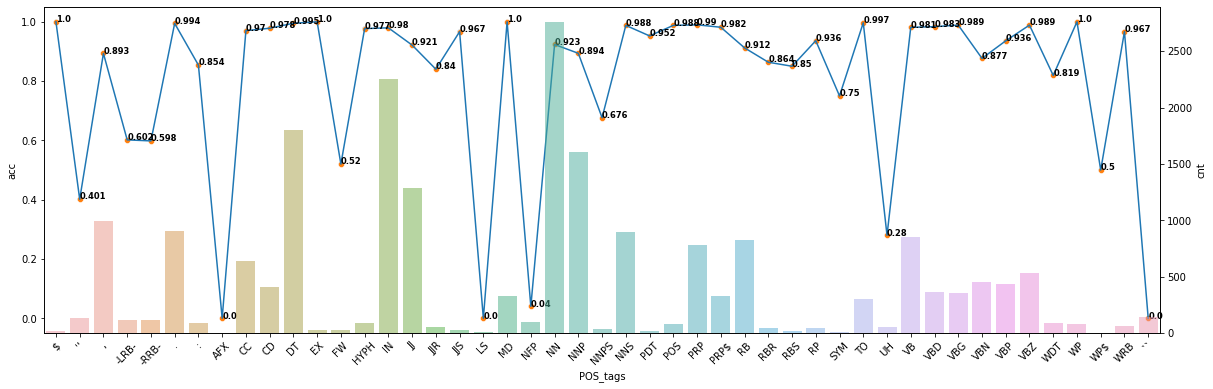

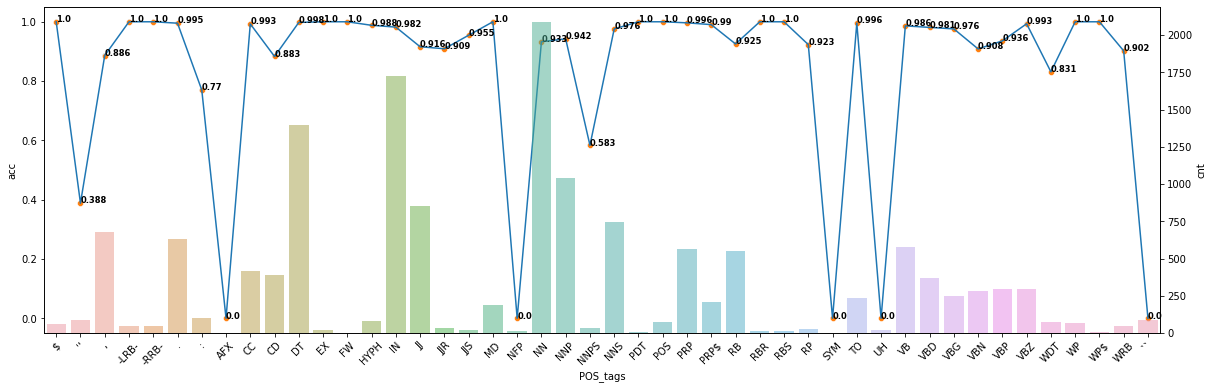

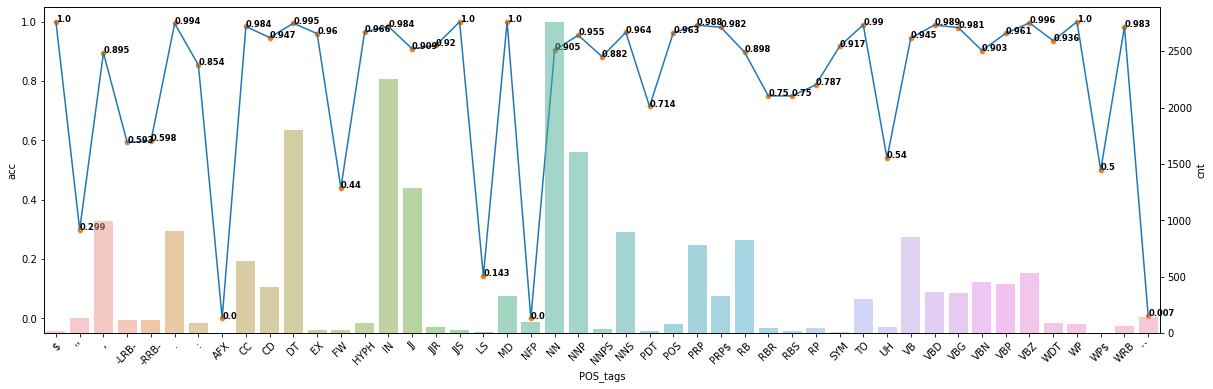

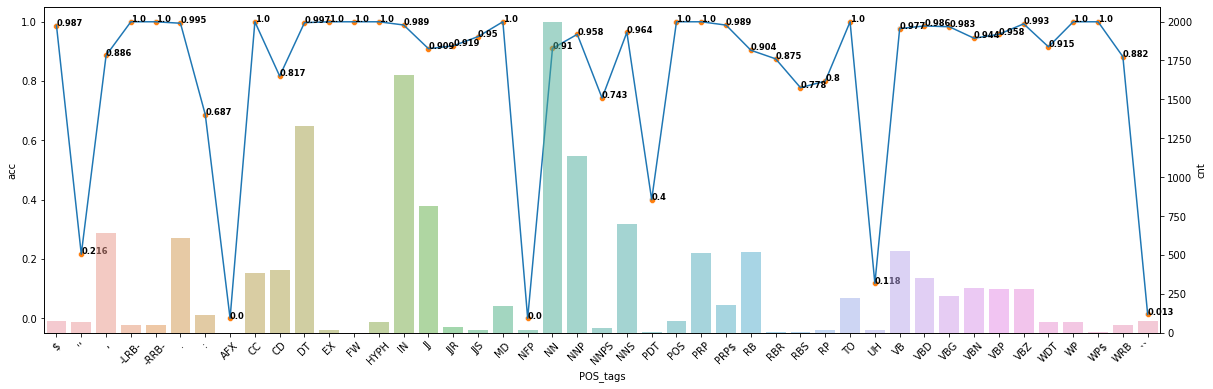

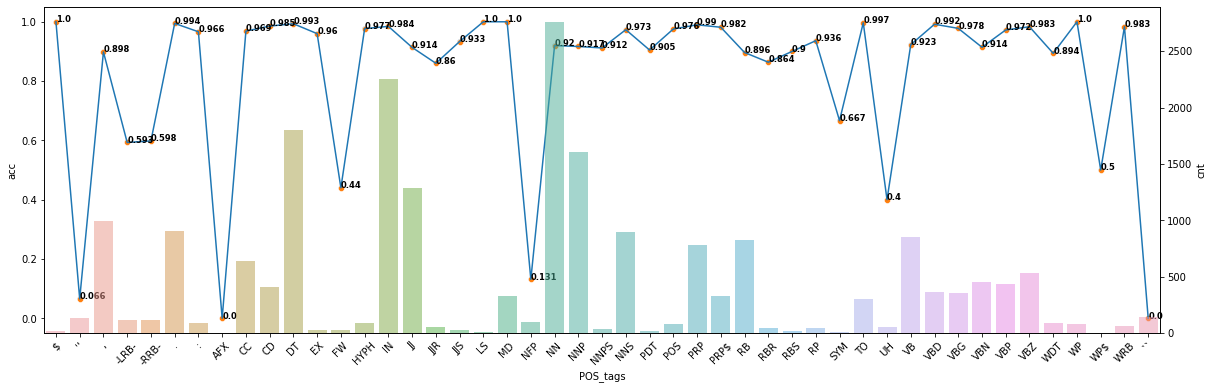

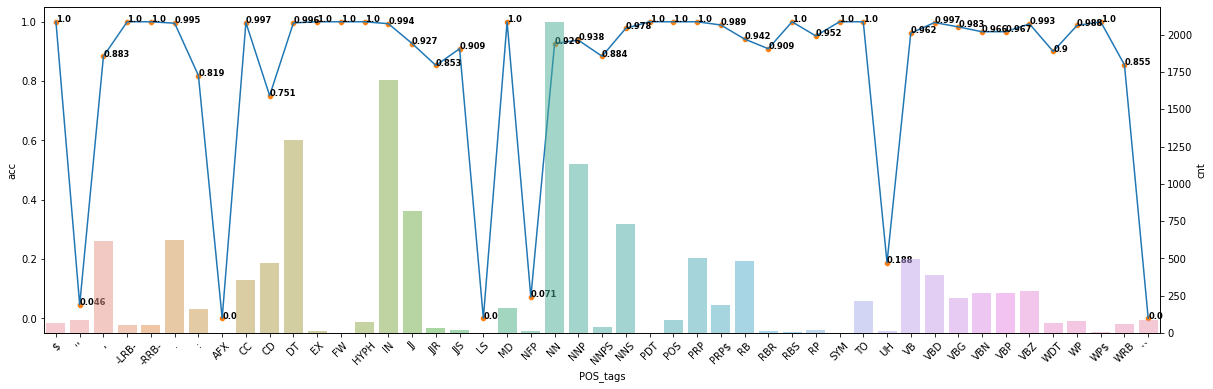

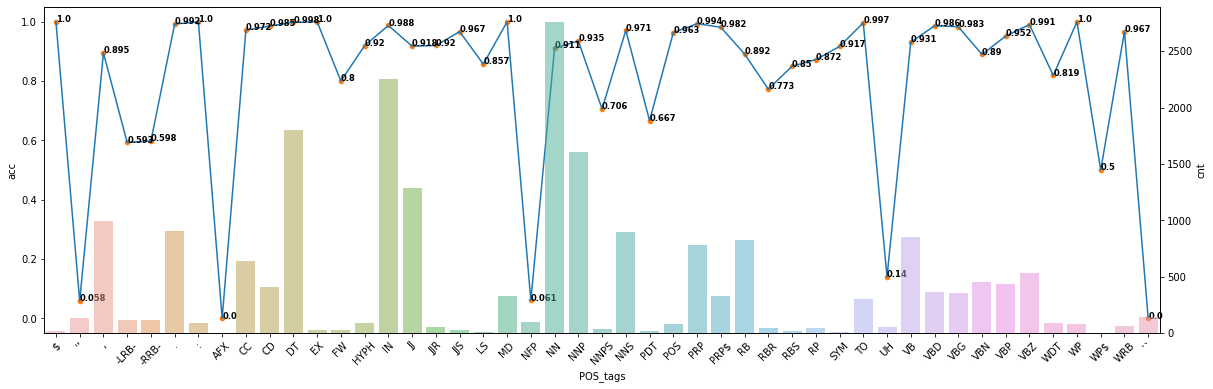

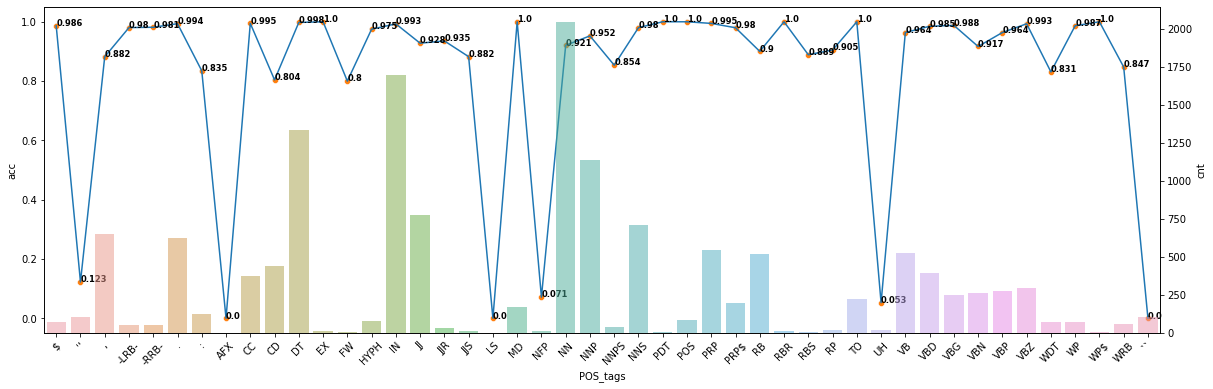

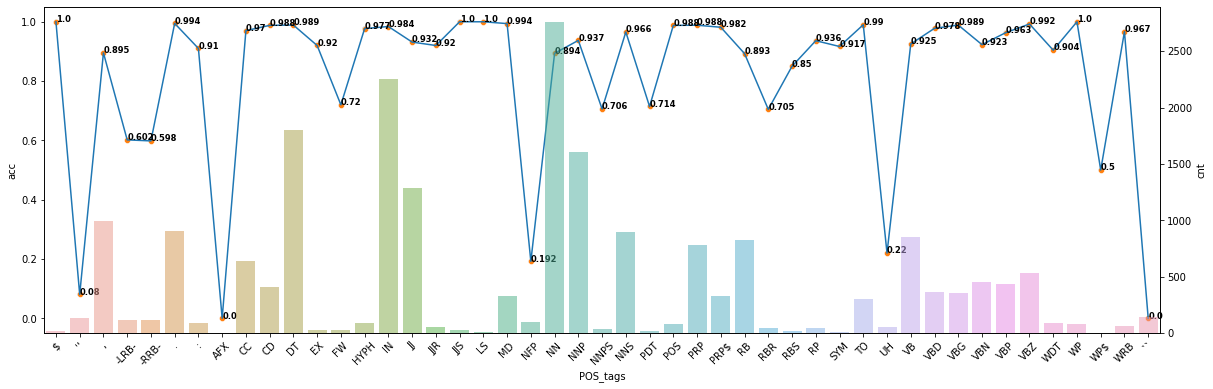

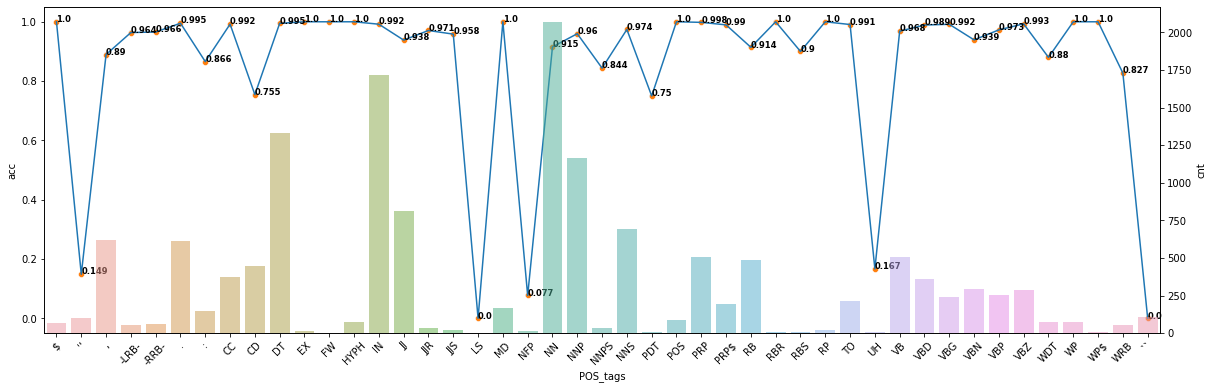

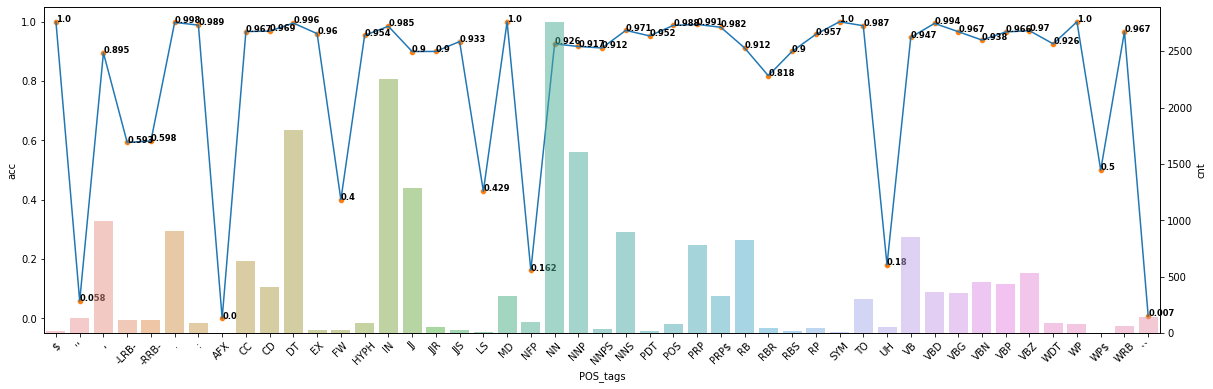

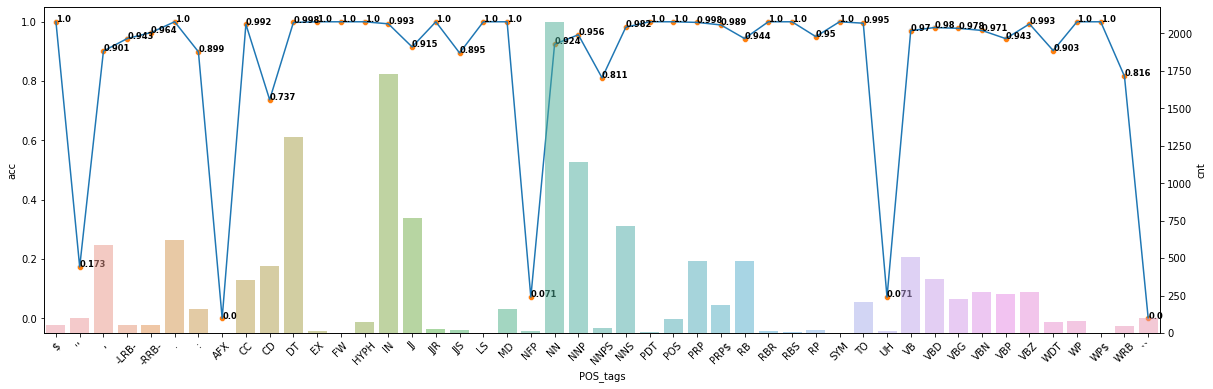

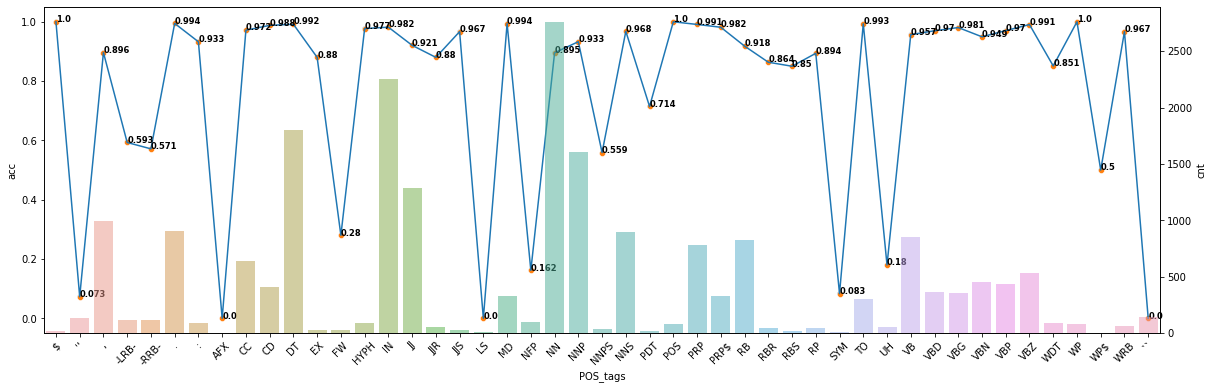

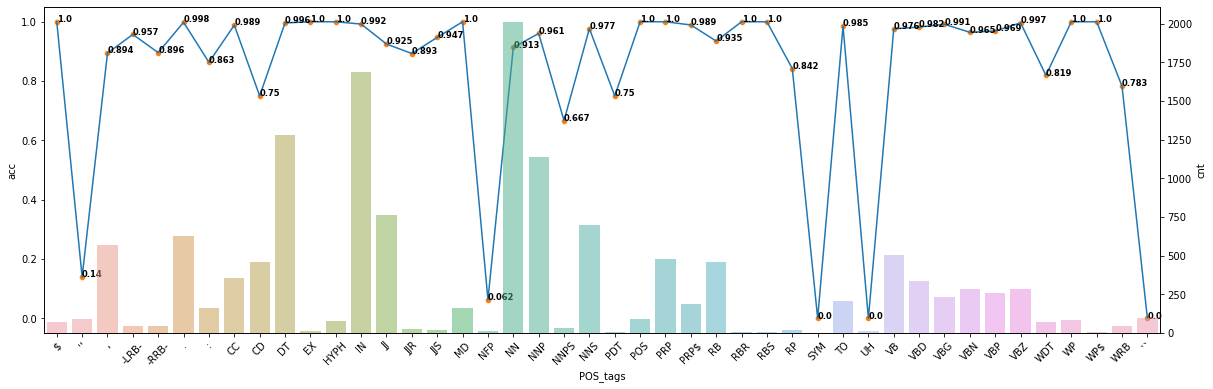

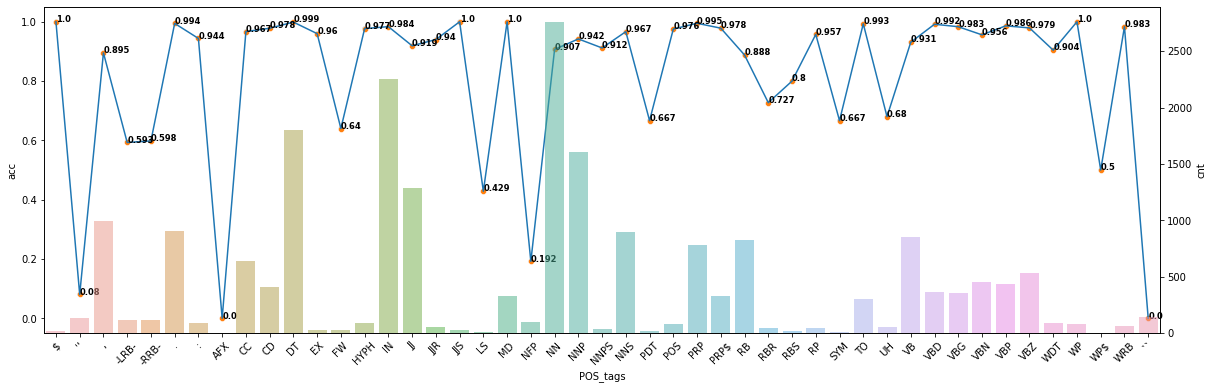

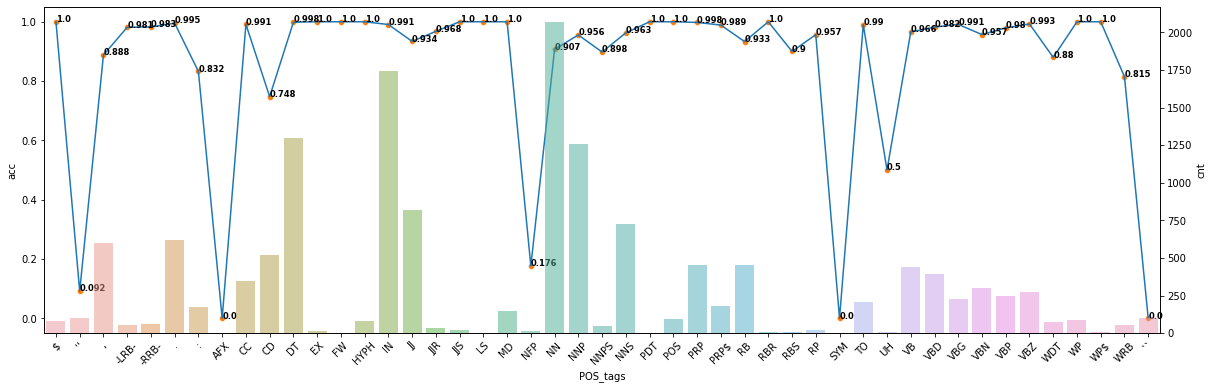

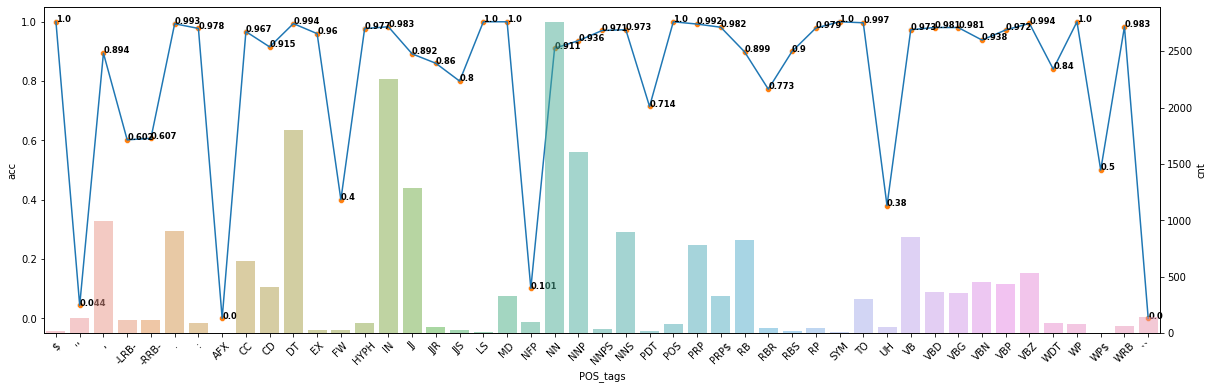

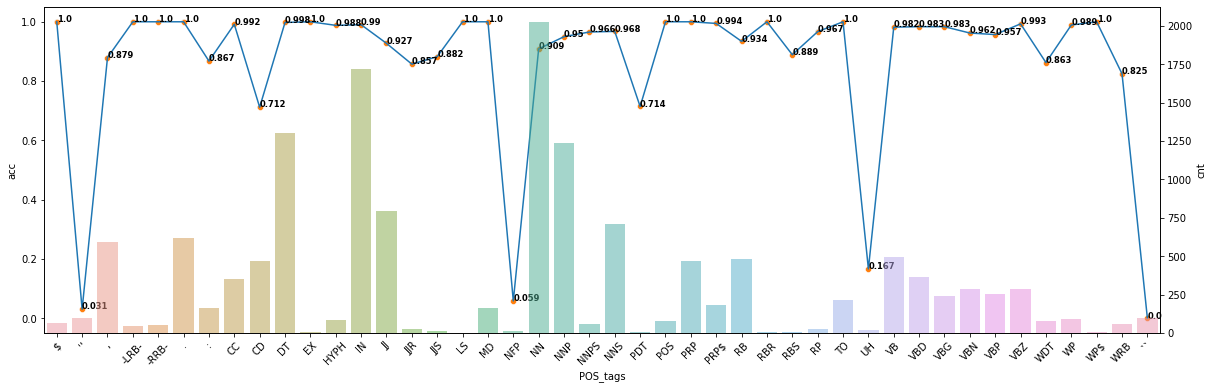

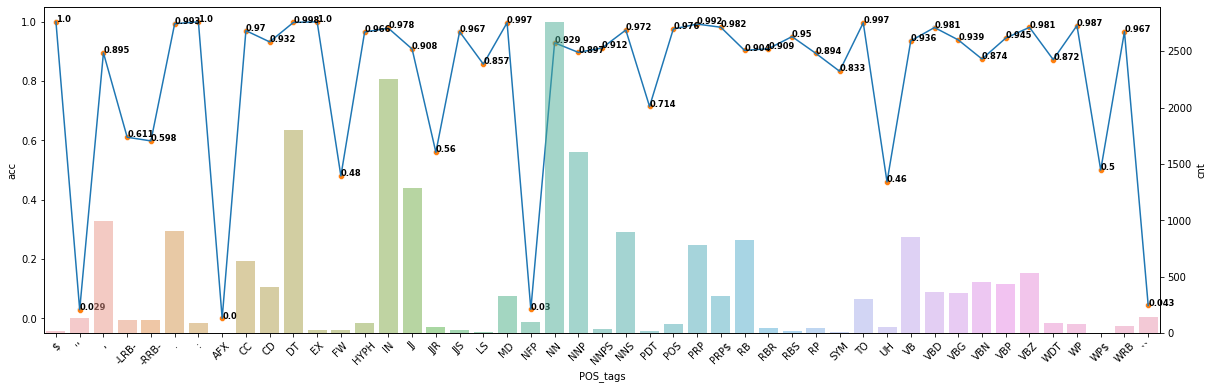

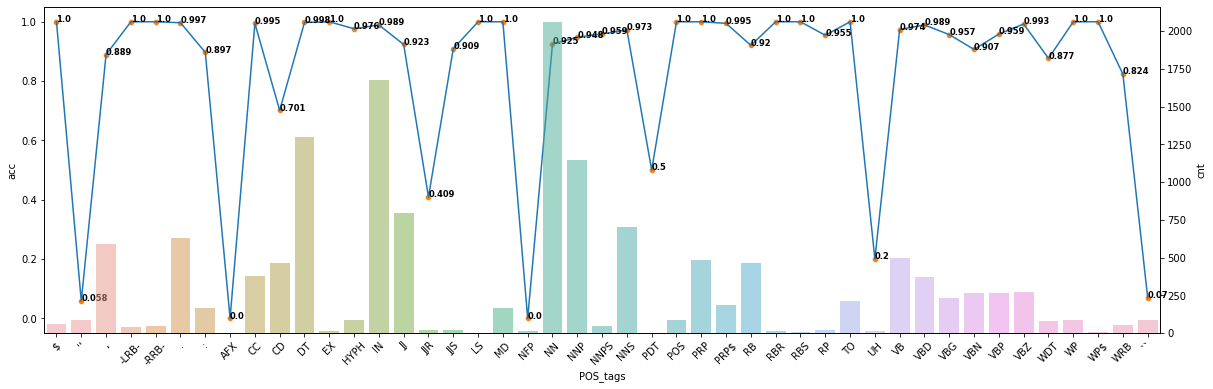

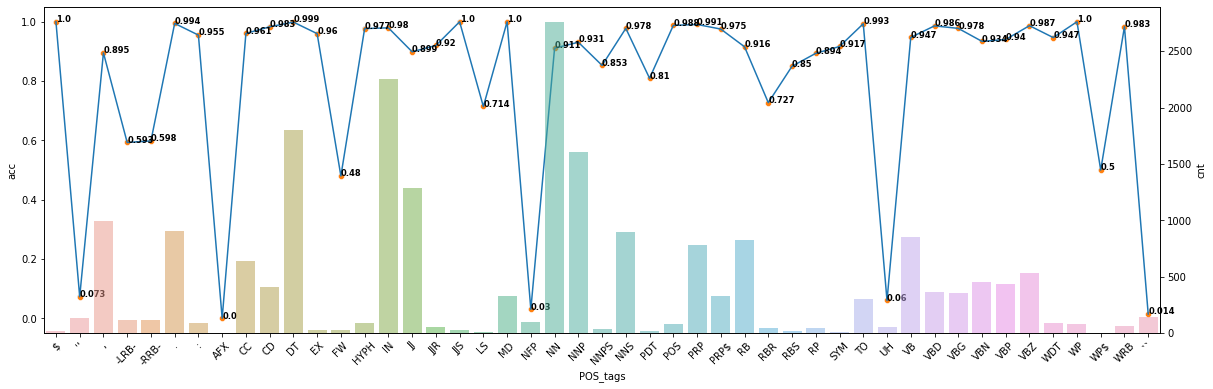

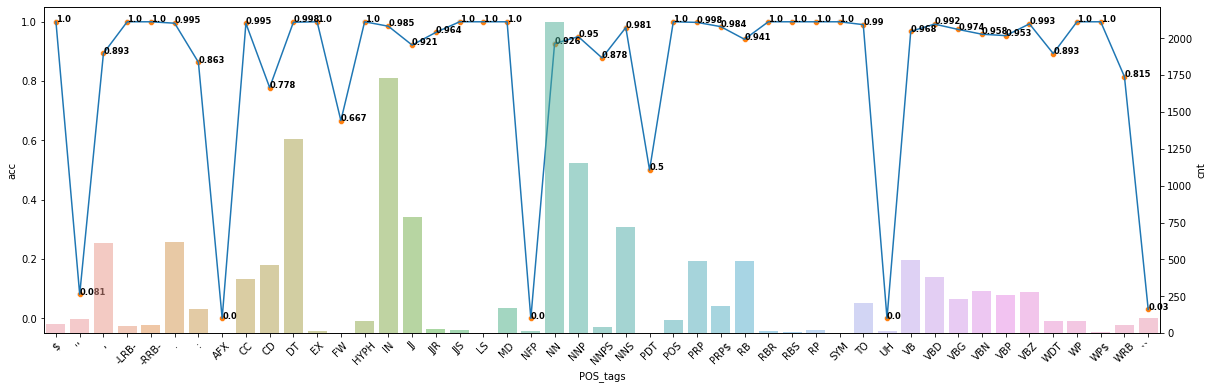

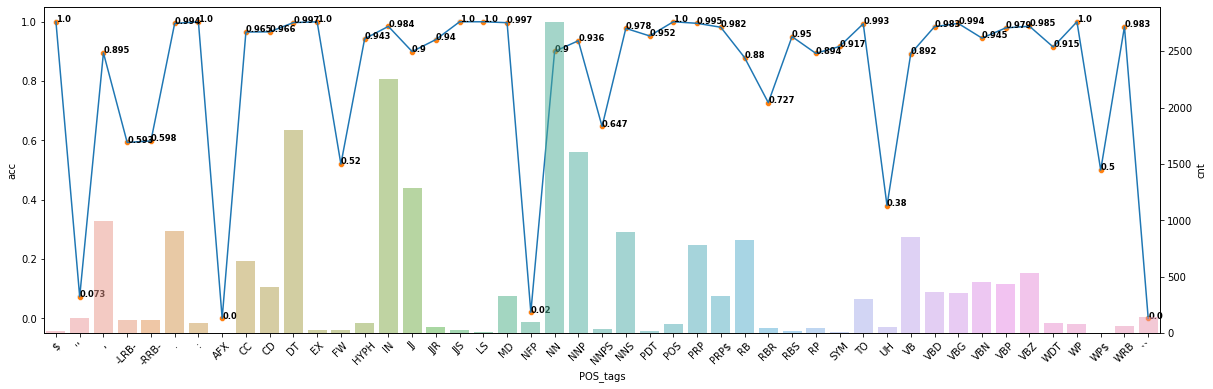

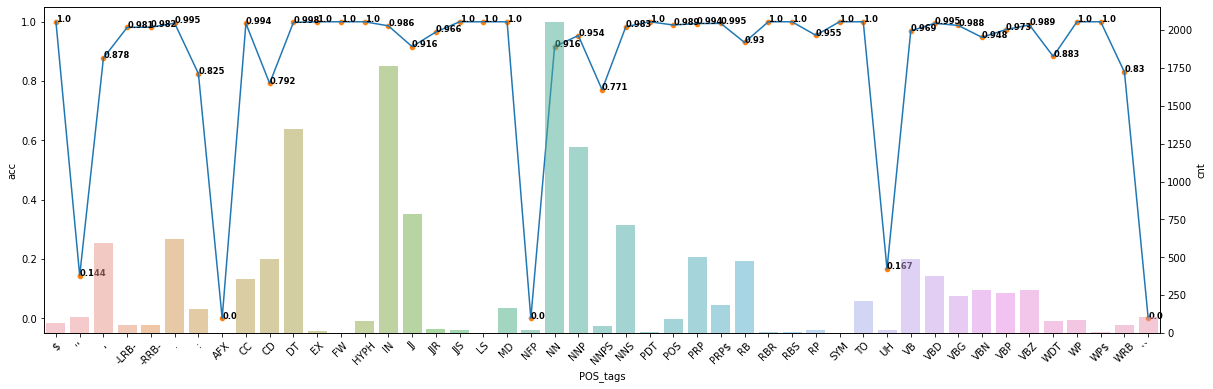

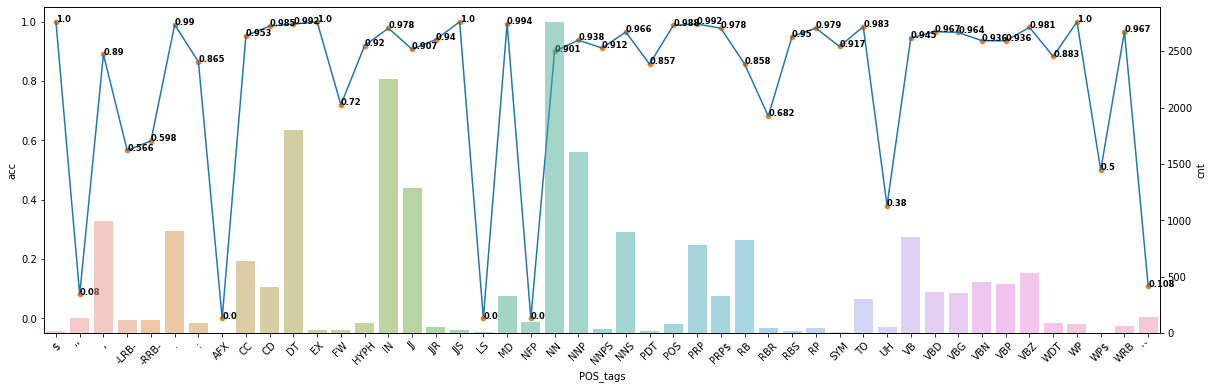

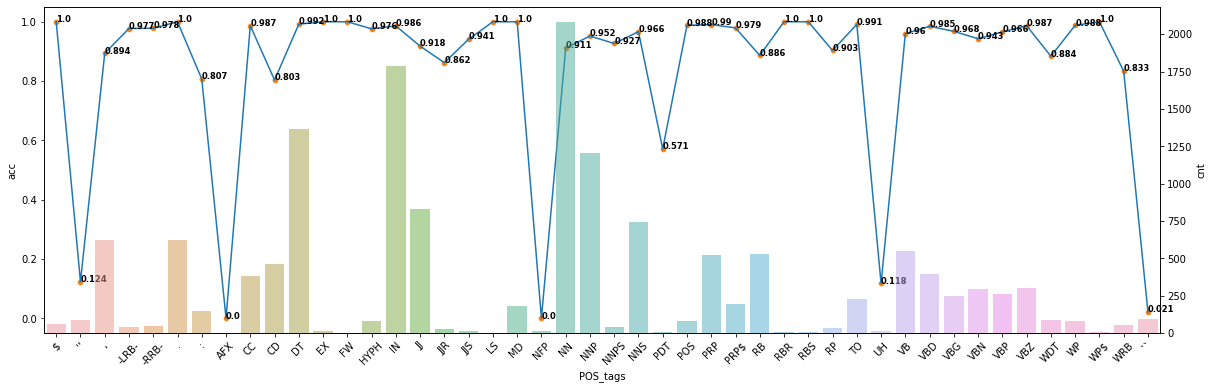

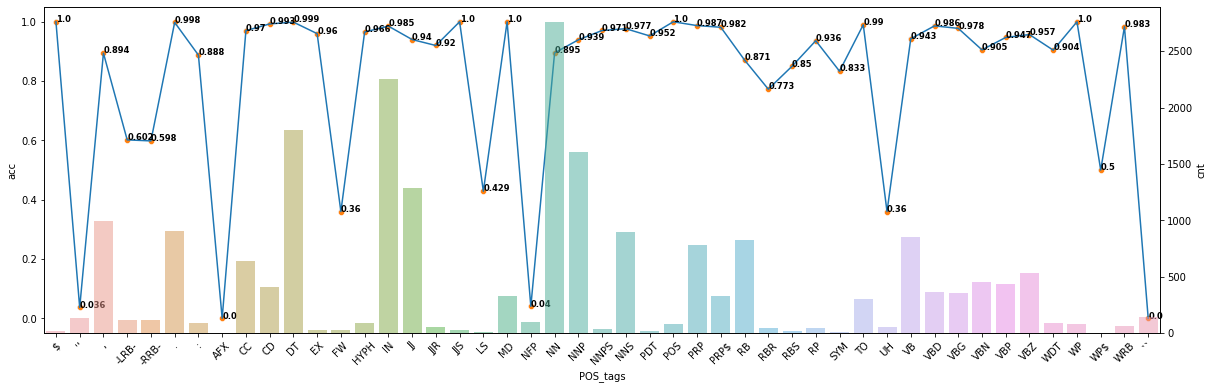

In [ ]:
acc_lst = []
prob_lst = []

topn = int(top_percent * len(domain_dev_word_lst))
print("The number of sentences in top n", topn)
print("Stop condation", int(threshold * topn))

last_top_sen = set()
top_words = domain_dev_word_lst[:topn]
new_top_sen = set([tuple(sen) for sen in top_words])

while len(new_top_sen.difference(last_top_sen)) > int(threshold * topn):
  loop_i += 1
  print("\nLoop", loop_i)
  print("Difference", len(new_top_sen.difference(last_top_sen)))

  domain_dev_dataset = PosDataset(domain_dev_word_lst, domain_dev_tag_lst)

  domain_dev_iter = data.DataLoader(dataset=domain_dev_dataset,
                              batch_size=8,
                              shuffle=False,
                              num_workers=1,
                              collate_fn=pad)
  
  # Save analysis outputs for intermediate results
  int_csv_file_name = os.path.join(sub_int_res_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.csv")
  int_output_plot_name = os.path.join(sub_int_res_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.png")
  output_int_res_file = os.path.join(sub_int_res_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.txt") 
  
  (top_words, top_tags, top_pseudo_tags, top_prob, top_acc, remain_words, 
   remain_tags, remain_pseudo_tags, remain_prob, remain_acc)= gen_pseudo_data(
       model, domain_dev_iter, topn, save_output=True, output_file=output_int_res_file, 
       csvsave=True, pngsave=True, csv_file_name=int_csv_file_name, output_plot_name=int_output_plot_name)
  
  last_top_sen = new_top_sen
  new_top_sen = set([tuple(sen) for sen in top_words])

  new_train_dataset = PosDataset(
      wsj_train_word_lst + top_words, 
      wsj_train_tag_lst + top_pseudo_tags)
  new_train_iter = data.DataLoader(dataset=new_train_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=1,
                              collate_fn=pad)
  
  # domain_dev_word_lst = remain_words
  # domain_dev_tag_lst = remain_tags
  
  print("Train from scratch...")
  model = Net(vocab_size=len(TAG2IDX))
  model.to(DEVICE)
  model = nn.DataParallel(model)

  optimizer = optim.Adam(model.parameters(), lr = 0.0001)
  criterion = nn.CrossEntropyLoss(ignore_index=0)

  train(model, new_train_iter, optimizer, criterion)

  # # Save models
  # model_file = os.path.join(sub_model_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.pt")
  # torch.save(model.state_dict(), model_file)

  # Save final results
  output_res_file = os.path.join(sub_result_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.txt")
  (domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value,
   precision_value_micro, recall_value_micro, f1_value_micro, acc_micro, 
   precision_value_macro, recall_value_macro, f1_value_macro, acc_macro) = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

  domain_precision_value_lst.append(domain_precision_value)
  domain_recall_value_lst.append(domain_recall_value)
  domain_f1_value_lst.append(domain_f1_value)
  domain_acc_value_lst.append(domain_acc_value)

  micro_domain_precision_value_lst.append(precision_value_micro)
  micro_domain_recall_value_lst.append(recall_value_micro)
  micro_domain_f1_value_lst.append(f1_value_micro)
  micro_domain_acc_value_lst.append(acc_micro)

  macro_domain_precision_value_lst.append(precision_value_macro)
  macro_domain_recall_value_lst.append(recall_value_macro)
  macro_domain_f1_value_lst.append(f1_value_macro)
  macro_domain_acc_value_lst.append(acc_macro)

  acc_lst.append(top_acc)
  prob_lst.append(top_prob)

  # Save analysis outputs for final results
  csv_file_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.csv")
  output_plot_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.png")
  _ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)

  if loop_i == 15:
    break


In [ ]:
def plot_metric(precision, recall, f1, acc):

  test_metric = pd.DataFrame({
      "Loop": list(range(len(precision))) * 4,
      "metric": ["precision"]*len(precision) + ["recall"]*len(recall) + ["f1"]*len(f1) + ["accuracy"]*len(acc),
      "value": precision + recall + f1 + acc
  })

  fig = px.line(test_metric, x="Loop", y="value", color='metric', markers=True)
  fig.show()
  return test_metric

In [ ]:
_ = plot_metric(domain_precision_value_lst, domain_recall_value_lst, domain_f1_value_lst, domain_acc_value_lst)

In [ ]:
_ = plot_metric(micro_domain_precision_value_lst, micro_domain_recall_value_lst, micro_domain_f1_value_lst, micro_domain_acc_value_lst)

In [ ]:
_ = plot_metric(macro_domain_precision_value_lst, macro_domain_recall_value_lst, macro_domain_f1_value_lst, macro_domain_acc_value_lst)